# Stellar Population Studies using MaStar SDSS Data 
## Statistical and Data Analysis Methods in Science Final Project 
- Abhinav Govindan Iyer 
- Hirak Kanti Ghosh
- Rohan Pratap Nair 


## Importing the Necessary Libraries 

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import fits
import matplotlib.pyplot as plt


## Defining Constants 

In [9]:
#Loading solar primitive
solar_radius, solar_mass = 695700000, 1.9884E30
solar_luminosity, solar_temperature, solar_g = 3.828E26, 5800, 274
G = 6.6743e-11
sb = 5.670e-8
c = 3e8

## Opening the MaStar Catalog and spectrum files

In [10]:
mastarall = fits.open('mastarall-v3_1_1-v1_7_7.fits')[1]
mastargood = fits.open('mastar-goodspec-v3_1_1-v1_7_7.fits')[1]

## Creating arrays containing various parameters

In [11]:
mastarall_manga_id = mastarall.data['MANGAID']
log_surface_gravity = mastarall.data['INPUT_LOGG']
effective_temperature = mastarall.data['INPUT_TEFF']
ra = mastarall.data['RA']
dec = mastarall.data['DEC']

_temp_df = pd.DataFrame([mastarall_manga_id, effective_temperature, log_surface_gravity]).T
_temp_df.columns = ['manga_id', 'effective_temperature', 'log_surface_gravity']

mastarall_df = _temp_df[(_temp_df['effective_temperature'] > 0) & (_temp_df['log_surface_gravity'] > 0)]
mastarall_df.reset_index(drop=True, inplace=True)

## Finding the maximum flux and $\lambda_{max}$ for each star from the spectral data

In [12]:
mastargood_manga_id = mastargood.data['MANGAID']
wave = mastargood.data['WAVE']
flux = mastargood.data['FLUX']

max_f = []
max_wav = []

for i in range (len(flux)):
    max_t = max(flux[i])
    max_index = np.argmax(flux[i])
    max_f.append(max_t)
    max_wav.append(wave[i][max_index])

## Plotting histogram of $\lambda_{max}$ and blackbody curve 

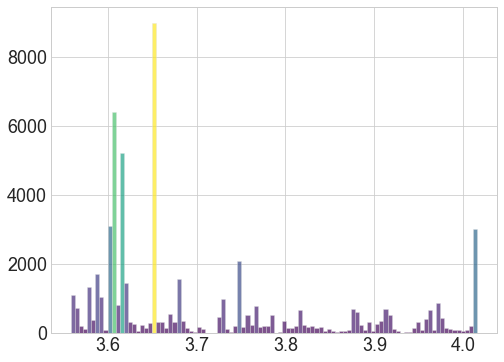

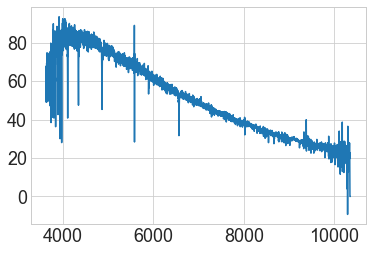

In [13]:
plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(np.log10(max_wav), bins=100, facecolor = '#2ab0ff',edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

plt.figure()
plt.plot(wave[0], flux[0])

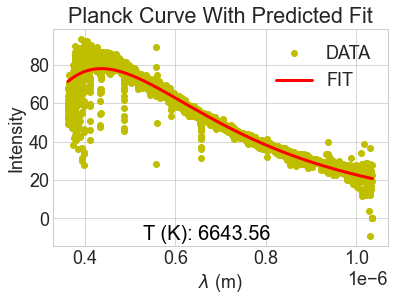

The best fit temperature in Kelvins is: 6643.56


c:\Users\abhin\Desktop\MSc_Semester_3\Stat_Astro\Final_Project\Data Science Project\blackbody__curve.py:160: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  planck_integral = np.abs(quad(blackbody, np.min(wavelength), np.max(wavelength), args = T))[0]
c:\Users\abhin\Desktop\MSc_Semester_3\Stat_Astro\Final_Project\Data Science Project\blackbody__curve.py:160: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  planck_integral = np.abs(quad(blackbody, np.min(wavelength),

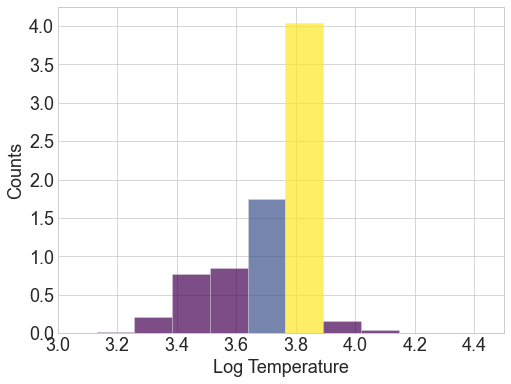

In [14]:
import blackbody_curve as bc
import blackbody__curve as bbc
bc.blackbody_fit(wave[0]/10, flux[0])

Temp_1 = []
for i in range (50000):
    Temp_1.append(bbc.blackbody_fit(wave[i]/10, flux[i]))

plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 6))
plt.xlim(3,4.5)
n, bins, patches = plt.hist(np.log10(Temp_1), bins=50, facecolor = '#2ab0ff',edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, density=True)
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
    
#plt.title("Histogram for Temperature corresponding to $\lambda_{max}$")
plt.xlabel("Log Temperature")
plt.ylabel("Counts")
plt.savefig('Temperature_hist.pdf',bbox_inches='tight')


## Defining functions to obtain mass, radius, luminosity 

In [15]:
def get_mass_of_star(temperature, surface_gravity):
    for i in range(len(temperature)) :     
    
        if temperature[i] < 3900:
            k_parameter, a = 0.23, 2.3
            numerator = G * solar_mass**a * temperature[i]**4
            denominator = surface_gravity * k_parameter * solar_radius**2 * solar_temperature**4
            out = pow(numerator / denominator, 1 / (a - 1))
        elif 3900 < temperature[i] < 7900:
            k_parameter, a = 1, 4
            numerator = G * solar_mass**a * temperature[i]**4
            denominator = surface_gravity * k_parameter * solar_radius**2 * solar_temperature**4
            out = pow(numerator / denominator, 1 / (a - 1))
        else:
            k_parameter, a = 1.4, 3.5
            numerator = G * solar_mass**a * temperature[i]**4
            denominator = surface_gravity * k_parameter * solar_radius**2 * solar_temperature**4
            out = pow(numerator / denominator, 1 / (a - 1))
    return out

In [16]:
def get_radius_of_star(mass, gravity):
    _p1 = G*mass
    _p1 = _p1/gravity
    return pow(_p1, 0.5)

def get_luminosity_of_the_star(radius, temperature):
    return 4*np.pi*pow(radius, 2)*sb*pow(temperature, 4)

In [17]:
def planck_function(wavelength, temperature):
    w, t = wavelength, temperature
    p1 = 2 * h * pow(c, 2)
    p1 = p1 / pow(w, 5)

    p2 = (h * c) / (w * k * t)
    p2 = np.exp(p2) - 1
    p2 = 1. / p2

    return p1 * p2

## Initialize mass, radius and luminosity arrays for the stellar data

In [18]:
mass = get_mass_of_star(effective_temperature, log_surface_gravity)
radius = get_radius_of_star(mass, log_surface_gravity)
luminosity = get_luminosity_of_the_star(radius, effective_temperature)

hot_ra = []
hot_dec = []
cold_ra = []
cold_dec = []
for i in range(len(effective_temperature)):
    if np.log10(effective_temperature[i]) < 4 : 
        cold_ra.append(ra[i])
        cold_dec.append(dec[i])
    else :
        hot_ra.append(ra[i])
        hot_dec.append(dec[i])

C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\2532020309.py:8: RuntimeWarning: invalid value encountered in power
  out = pow(numerator / denominator, 1 / (a - 1))
C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\2532020309.py:13: RuntimeWarning: invalid value encountered in power
  out = pow(numerator / denominator, 1 / (a - 1))
C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\2532020309.py:18: RuntimeWarning: invalid value encountered in power
  out = pow(numerator / denominator, 1 / (a - 1))
C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\184488402.py:10: RuntimeWarning: invalid value encountered in log10
  if np.log10(effective_temperature[i]) < 4 :


## Plotting Histograms for mass, temperature, radius, luminosity and surface gravity

C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\3626448600.py:17: RuntimeWarning: invalid value encountered in log10
  ninf_temp = np.log10(effective_temperature)
C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\3626448600.py:28: RuntimeWarning: invalid value encountered in log10
  n, bins, patches = plt.hist(np.log10(effective_temperature), bins=50, facecolor = '#2ab0ff',edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, density=True)
C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\3626448600.py:45: RuntimeWarning: invalid value encountered in log10
  sns.kdeplot(data=np.log10(effective_temperature), color='blue', linestyle=':', bw_adjust=0.8, label='KDE Fit')


(0.21186442768420366, 3.298705821047841, 0.39519332351256675)
Normal Mean  3.7028613 STD  0.086344555
LogNOrmal Mean 3.298705821047841 lognormal std 0.39519332351256675


C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\3626448600.py:53: RuntimeWarning: invalid value encountered in log10
  ninf_g = np.log10(log_surface_gravity)
C:\Users\abhin\AppData\Local\Temp\ipykernel_3516\3626448600.py:61: RuntimeWarning: invalid value encountered in long_scalars
  patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))


Normal Mean  29.069089805303573 STD  0.3450689117120821
LogNormal Mean 0.30986379321883906


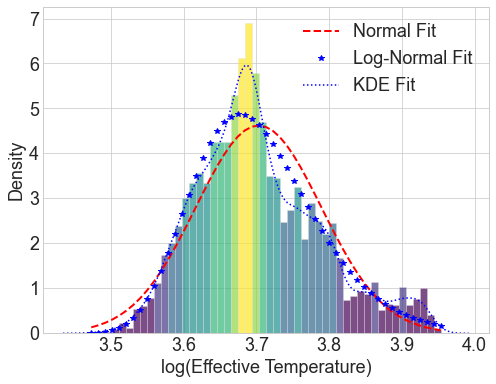

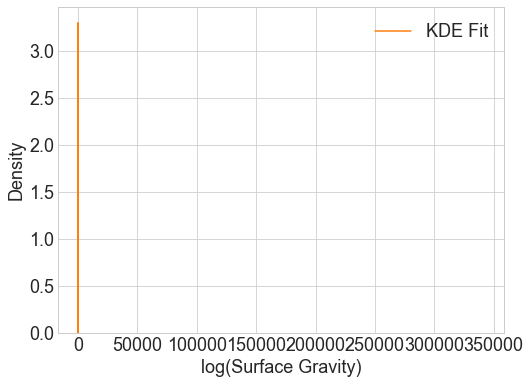

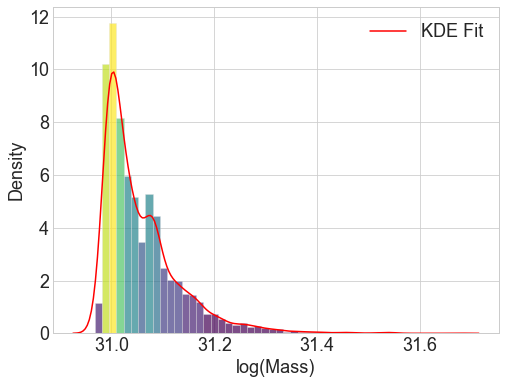

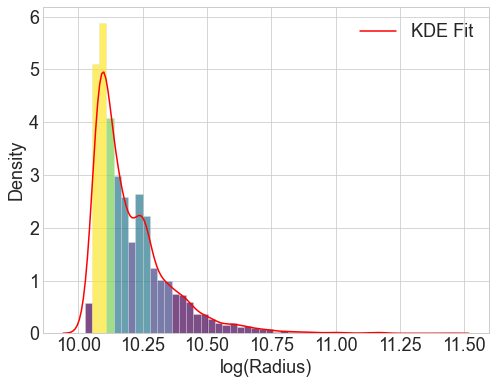

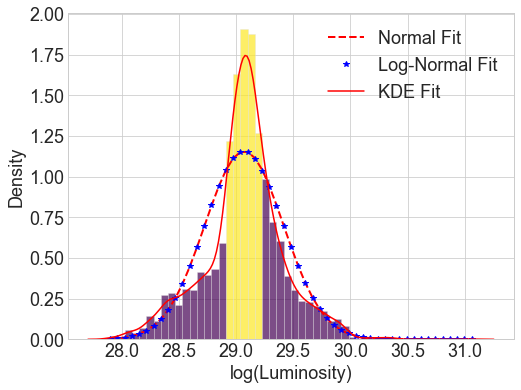

In [19]:
import scipy
import matplotlib.mlab as mlab
import math as m
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.optimize import curve_fit

# Picking out the non-infinite and non NaN values from the data 
ninf_temp = np.log10(effective_temperature)
ninf_temp = ninf_temp[~np.isnan(ninf_temp)]
(mu, sigma) = scipy.stats.norm.fit(ninf_temp)
log_n_params = scipy.stats.lognorm.fit(ninf_temp)
print(log_n_params)


""" Effective Temperature """

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(np.log10(effective_temperature), bins=50, facecolor = '#2ab0ff',edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, density=True)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

y = scipy.stats.norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2,label='Normal Fit')

y_ = scipy.stats.lognorm.pdf(bins, log_n_params[0],log_n_params[1], log_n_params[2])
l_ = plt.plot(bins, y_, 'b*', linewidth=2, label='Log-Normal Fit')

print("Normal Mean ",mu, "STD ", sigma)
print('LogNOrmal Mean', log_n_params[1], "lognormal std", log_n_params[2])

""" KDE Fit """

sns.kdeplot(data=np.log10(effective_temperature), color='blue', linestyle=':', bw_adjust=0.8, label='KDE Fit')
plt.legend()
plt.xlabel('log(Effective Temperature)')
plt.savefig('eff_temp_hist.pdf', bbox_inches='tight')


""" Surface Gravity """

ninf_g = np.log10(log_surface_gravity)
ninf_g = ninf_g[~np.isnan(ninf_g)]

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(pow(10,log_surface_gravity), bins=50, facecolor = '#2ab0ff',edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7,density=True)
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

sns.kdeplot(data=ninf_g, bw_adjust=1, label='KDE Fit')
plt.legend()
plt.xlabel('log(Surface Gravity)')
plt.savefig('logg_hist.pdf', bbox_inches='tight')

""" Mass """

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(np.log10(mass), bins=50, facecolor = '#2ab0ff',edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, density=True)
sns.kdeplot(data=np.log10(mass), color='red',label='KDE Fit')
plt.legend()
plt.xlabel('log(Mass)')
plt.savefig('mass_hist.pdf', bbox_inches='tight')
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

""" Radius """

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 6))
n,bins,patches = plt.hist(np.log10(radius), bins=50, facecolor = '#2ab0ff',edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, density=True)

sns.kdeplot(data=np.log10(radius), color='red',label='KDE Fit' )
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
plt.legend()
plt.xlabel('log(Radius)')
plt.savefig('radius_hist.pdf', bbox_inches='tight')

"""Luminosity"""

ninf_lum = np.log10(luminosity)
ninf_lum = ninf_lum[~np.isnan(ninf_lum)]
(mu_l, sigma_l) = scipy.stats.norm.fit(ninf_lum)
log_lum_params = scipy.stats.lognorm.fit(ninf_lum)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(ninf_lum, bins=50, facecolor = '#2ab0ff',edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, density=True)
y_lum = scipy.stats.norm.pdf( bins, mu_l, sigma_l)
l_lum = plt.plot(bins, y_lum, 'r--', linewidth=2,label='Normal Fit')

y_lum_ = scipy.stats.lognorm.pdf(bins, log_lum_params[0],log_lum_params[1], log_lum_params[2])
l_lum_ = plt.plot(bins, y_lum_, 'b*', linewidth=2, label='Log-Normal Fit')

print("Normal Mean ",mu_l, "STD ", sigma_l)
print('LogNormal Mean', y_lum.mean())

sns.kdeplot(data=np.log10(luminosity), color='red',label='KDE Fit' )
n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
plt.legend()
plt.xlabel('log(Luminosity)')
plt.savefig('luminosity.pdf', bbox_inches='tight')



## Picking out non NaN values from the dataset 

In [20]:
reject = []
for i in range (len(mass)):
    if(~np.isnan(mass[i]) == True): 
        reject.append(i)
        #print(log_surface_gravity[i])

temp = []
g = []
lum  =[]
rad = []
ra_ = []
dec_ = []

for i in reject: 
    temp.append(effective_temperature[i])
    g.append(log_surface_gravity[i])
    lum.append(luminosity[i])
    rad.append(radius[i])
    ra_.append(ra[i])
    dec_.append(dec[i])
    

## Plotting skymap of stars in galactic coordinate system

c:\Users\abhin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


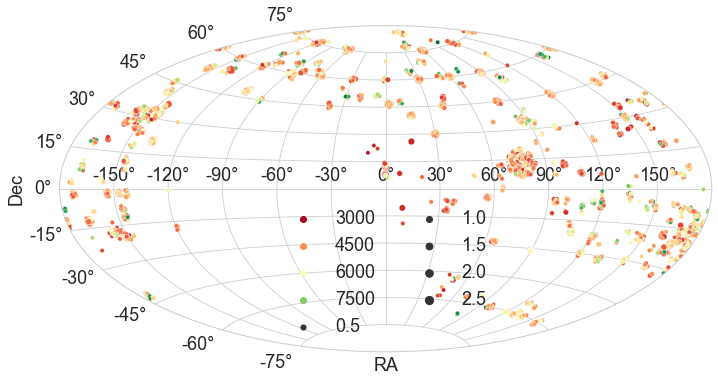

In [21]:
eq = SkyCoord(ra_[:], dec_[:], unit=u.deg)
gal = eq.galactic
fig, ax = plt.subplots(figsize=(12,6))
plt.subplot(111, projection='aitoff')
sns.scatterplot(gal.l.wrap_at('180d').radian, gal.b.radian, hue = temp, size = rad, palette='RdYlGn')
plt.legend(loc = 'best', ncol=2)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(True)
plt.savefig('gal_center_plot.pdf', bbox_inches='tight')

In [22]:
print(len(mass))
mass = mass[~np.isnan(mass)]
#effective_temperature = effective_temperature[np.isnan(effective_temperature)]
#log_surface_gravity = log_surface_gravity[np.isnan(log_surface_gravity)]
print("mass", len(mass))
print("temp", len(temp))
print("g", len(g))



24290
mass 4256
temp 4256
g 4256


## Plotting HR Diagrams 

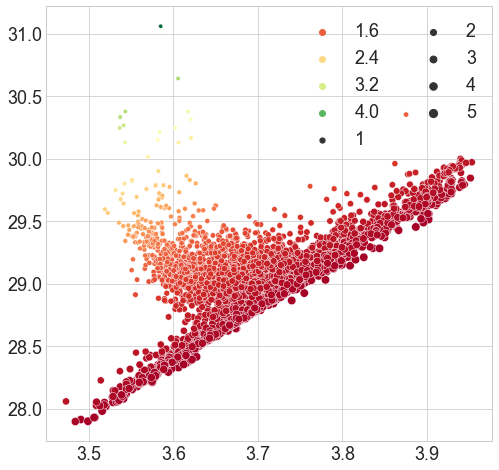

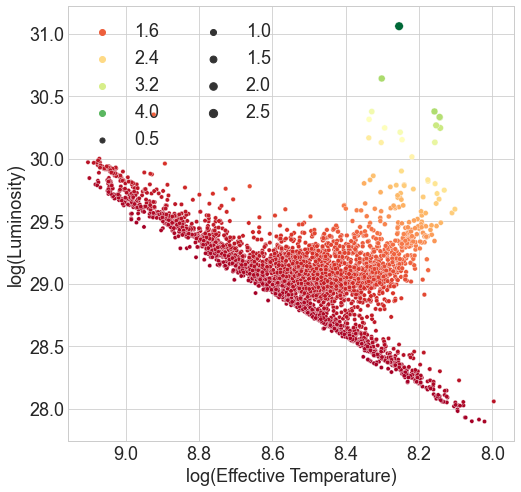

In [23]:
plt.figure(figsize=(8, 8)) 
sns.scatterplot(x= np.log10(temp), y= np.log10(lum), hue=mass ,size = g, palette='RdYlGn') 
plt.legend(loc='best', ncol=2)
plt.show()

plt.figure(figsize=(8, 8)) 
sns.scatterplot(x = np.log(temp), y=np.log10(lum), hue=mass ,size = rad, palette='RdYlGn')
plt.xlabel('log(Effective Temperature)')
plt.ylabel('log(Luminosity)')
plt.gca().invert_xaxis()
plt.legend(loc='best', ncol=2)
plt.savefig('lum_vs_temp.pdf', bbox_inches='tight')
plt.show()

## PCA Analysis

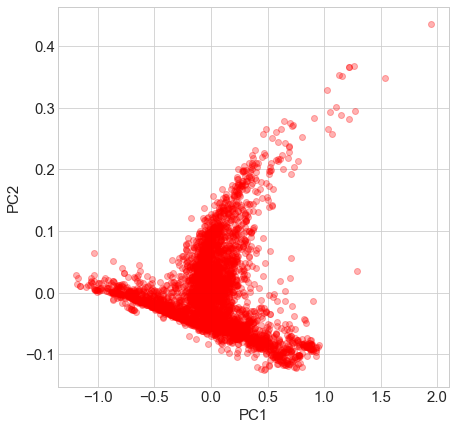

96.51044792298357 3.489552077016421


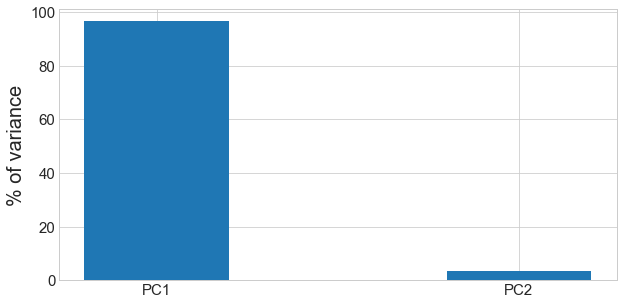

Eigen vectors are [[-0.98704198 -0.16046227]
 [ 0.16046227 -0.98704198]]
Eigen values are [1.03782340e-06 2.87030539e-05]
Percentage Eigen values are 0.03489552077016413 0.9651044792298359


In [25]:
from sklearn.decomposition import PCA
X=[np.log10(temp),np.log10(lum)]
X=np.array(X).T


Xt = PCA().fit_transform(X)
plt.figure(figsize=(7,7))
plot = plt.scatter(Xt[:,0],Xt[:,1],color='red',alpha=0.3)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
plt.show()


## Estimating the variances of the data in different PC
var_pc1 = np.divide(np.sum(np.power(Xt[:,0],2)),len(Xt[:,0]) -1)
var_pc2 = np.divide(np.sum(np.power(Xt[:,1],2)),len(Xt[:,1]) -1)
pervar_pc1 = var_pc1*100/(var_pc1+var_pc2)
pervar_pc2 = var_pc2*100/(var_pc1+var_pc2)
print(pervar_pc1,pervar_pc2)

### creating the scree plot which tells you each PC has how much % of the variance of the data
fig = plt.figure(figsize = (10, 5))
plt.bar(['PC1','PC2'], [pervar_pc1,pervar_pc2],width = 0.4)
plt.ylabel("% of variance",fontsize=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.show()

#For estimating the Eigen values and vectors
M = np.mean(X.T, axis=1)
C = X - M
V = np.cov(C.T)

values, vectors = np.linalg.eig(V)

var = values/(len(Xt[:,0])-1)
print('Eigen vectors are',vectors)
print('Eigen values are',values/(len(Xt[:,0])-1))
print('Percentage Eigen values are',var[0]/(np.sum(var)), var[1]/(np.sum(var)))

## Plotting Covariance Matrix (or) Heatmap

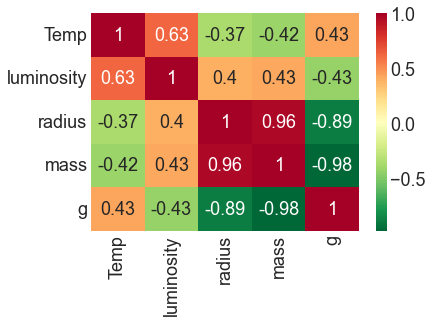

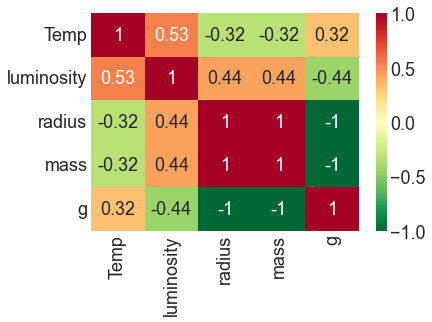

In [26]:
h = {'Temp': np.log10(temp), 'luminosity':np.log10(lum), 'radius': rad, 'mass':mass, 'g':np.log10(g)}
heat = pd.DataFrame(h)
plt.figure(1)
sns.heatmap(heat.corr(), annot=True, cmap='RdYlGn_r', yticklabels=True)
plt.savefig('pear_corr.pdf', bbox_inches='tight')

plt.figure(2)
sns.heatmap(heat.corr(method='spearman'), annot=True, cmap='RdYlGn_r', yticklabels=True)
plt.savefig('spear_corr.pdf', bbox_inches='tight')